In [18]:
import numpy as np
import pandas as pd 
import sys
import os 
import pickle
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
# from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping
import sklearn.metrics as sklm
seed = 19
np.random.seed(seed)
tf.random.set_seed(seed)


In [19]:

print(sys.version)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


In [20]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.pardir)))

In [21]:
root_dir = os.path.dirname(os.path.dirname('__file__'))
print(root_dir)

In [22]:
medclip_embedding_folder = os.path.join(root_dir,"biomedclip-embedding")
os.makedirs(medclip_embedding_folder, exist_ok=True)
medclip_embedding_path = os.path.join(
    medclip_embedding_folder, "embedding_from_biomedclip.pkl")
print(medclip_embedding_path)

biomedclip-embedding\embedding_from_biomedclip.pkl


In [23]:
metadata_df=pd.read_csv("./dataframes/chexpert_df.csv")
metadata_df.head(5)

,Ids,Path,race,Sex,Age,age_decile,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,CheXpert-v1.0-small/train/patient39734/study6/...,Unknown,Male,64,60-80,Frontal,AP,0,0,...,0,-1,0,-1,0,0,1,0,0,0
1,1,CheXpert-v1.0-small/train/patient29203/study7/...,WHITE,Male,63,60-80,Frontal,PA,0,-1,...,0,0,-1,0,0,-1,-1,0,0,0
2,2,CheXpert-v1.0-small/train/patient36764/study19...,WHITE,Female,75,60-80,Frontal,AP,0,0,...,0,0,0,0,0,0,-1,0,0,1
3,3,CheXpert-v1.0-small/train/patient11447/study17...,WHITE,Male,48,40-60,Frontal,AP,0,0,...,0,0,0,0,0,0,1,0,0,1
4,4,CheXpert-v1.0-small/train/patient26111/study2/...,OTHER,Female,31,20-40,Frontal,AP,0,-1,...,0,0,0,0,0,0,0,0,0,1


In [24]:
metadata_df['ids'] = range(len(metadata_df))

In [25]:
print('=============================== Load embedding and target ======================================')
if os.path.exists(medclip_embedding_path):
    with open(medclip_embedding_path, 'rb') as f:
        X, y, valid_id, ids = pickle.load(f)

=============================== Load embedding and target ======================================


In [26]:
# X is 2D numpy array of shape (200452, 512) 
bioClipdf = pd.DataFrame({
    'ids': range(len(X)),        # Create an 'id' column starting from 0
    'emb': list(X),# The 'emb' column holds the embeddings
})
bioClipdf.columns = ['ids', 'emb']

In [27]:
bioClipdf = bioClipdf[~bioClipdf['emb'].apply(lambda x: np.all(np.array(x) == 0.0))]

bioClipdf.shape


(222822, 2)

In [28]:
df=bioClipdf.merge(metadata_df,on='ids',how="inner")
df = df[~df['emb'].apply(lambda x: np.all(np.array(x) == 0.0))]

In [29]:
df.columns


Index(['ids', 'emb', 'Ids', 'Path', 'race', 'Sex', 'Age', 'age_decile',
       'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum',
       'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
       'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
       'Pleural Other', 'Fracture', 'Support Devices'],
      dtype='object')

In [30]:
# Define the desired order of columns
olumns_order = ['Path','race','Sex','age_decile', 'Frontal/Lateral', 'AP/PA','emb',
                'Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation',
                'Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other',
                'Fracture','Support Devices','No Finding']
# Reorder the columns in the merged DataFrame
df = df[olumns_order]


In [31]:
labels_Columns=['Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                'Fracture', 'Support Devices', 'No Finding']

df[labels_Columns]=df[labels_Columns].astype("float64")

In [32]:
df['path_splited'] = df['Path'].str.split('/')
df['patientid'] = df['path_splited'].apply(lambda x: x[2])

# Insert 'patient_id' column at the second position
df.insert(1, 'patient_id', df['patientid'])

# Drop the intermediate 'path_splited' column
df.drop('path_splited', axis=1, inplace=True)
df.drop('patientid', axis=1, inplace=True)

In [33]:
df[labels_Columns] = df[labels_Columns].replace(-1.0, 0.0)

In [34]:
unique_pathId = df.patient_id.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_path_id = shuffle(unique_pathId)
value1 = (round(len(unique_path_id)*train_percent))
value2 = (round(len(unique_path_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_path_id)*test_percent))

In [35]:
print("Patients in training set: " + str(value1))

Patients in training set: 47132


In [36]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 5892


In [37]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 5892


In [38]:
df = shuffle(df)

train_path_id = unique_path_id[:value1]
validate_path_id = unique_path_id[value1:value3]
test_path_id = unique_path_id[value3:]

print(type(train_path_id))
print(train_path_id)

<class 'numpy.ndarray'>
['patient47099' 'patient01426' 'patient62616' ... 'patient27137'
 'patient15811' 'patient34633']


In [39]:
df.insert(7, "split","none", True)

In [40]:
df.loc[df.patient_id.isin(train_path_id), "split"]="train"
df.loc[df.patient_id.isin(validate_path_id), "split"]="validate"
df.loc[df.patient_id.isin(test_path_id), "split"]="test"


In [41]:
df.split.value_counts()

split
train       178119
test         22398
validate     22305
Name: count, dtype: int64

In [42]:
df_train = df[df["split"] == "train"]
df_validate = df[df["split"] == "validate"]
df_test = df[df["split"] == "test"]

In [43]:
# Create tf.data.Dataset objects for the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.emb.values.tolist(), df_train[labels_Columns].values))

In [44]:

# Create tf.data.Dataset objects for the datasets
validation_dataset = tf.data.Dataset.from_tensor_slices((df_validate.emb.values.tolist(), 
                                                         df_validate[labels_Columns].values))

In [45]:
# Create tf.data.Dataset objects for the datasets
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.emb.values.tolist(), 
                                                         df_test[labels_Columns].values))

for record_ in test_dataset.take(1):
    print(record_)

(<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([-2.52827644e+00, -2.73314929e+00, -2.25194874e+01,  1.76190758e+00,
       -8.13132823e-02,  5.90191066e-01, -2.02042675e+00,  3.24216843e+00,
       -3.64443827e+00, -1.85935259e+00,  1.39303878e-01, -4.52414036e-01,
       -2.83769751e+00, -1.24786854e+00,  2.59242344e+00, -3.29066467e+00,
       -4.43732738e-03,  2.84692264e+00, -5.48546791e-01,  6.13512993e-01,
        3.60663831e-01, -1.45759487e+00,  1.02198958e+00, -1.47407055e+00,
       -1.65611446e+00, -1.54040229e+00,  9.63267982e-01, -4.14039046e-01,
        6.30937767e+00, -2.62229323e+00,  1.95765936e+00,  1.66747451e+00,
       -2.87865400e-01,  4.01815057e-01,  2.38236284e+00,  2.45617938e+00,
        4.15446281e+00,  3.92585897e+00, -7.18697357e+00, -1.13032949e+00,
        2.74335957e+00, -3.82473969e+00, -6.78174686e+00,  3.00571871e+00,
        2.37133503e+00,  6.73607707e-01, -4.24187869e-01,  1.92160857e+00,
       -3.02830696e+00, -2.52796602e+00, -3.4840056

In [46]:
df_test=df_test.drop(columns='emb',axis=1)
df_validate=df_validate.drop(columns='emb',axis=1)

In [47]:
df_validate.to_csv("df_validate.csv",index=False)
df_test.to_csv("df_test.csv",index=False)

In [48]:
# These parameters are obtained by doing hyperparameter tuning 
embeddings_size=512
learning_rate=0.0001253
batch_size = 256
epochs = 50
end_lr_factor=1.0
dropout=0.3
decay_steps=1000
loss_weights=None
weight_decay = 1.1342834436836775e-05

hidden_layer_sizes = [768,256]

In [49]:
checkpoint_path = medclip_embedding_folder+"/Seed_"+str(seed)+"/model_checkpoint_seed_"+str(seed)+"/"
# Create directory model weightes saving
save_model_dir = os.path.join(checkpoint_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

def get_callbacks(patience=5,fold=1):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)

    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model_{fold}.keras',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,saved_model,]
    return callbacks_list

In [50]:
# Define a function to build the model
def build_model(
    # hp
    ):
    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model


In [51]:
model=build_model()

In [52]:
# Plot the model architecture
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
model.summary()
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,542 (2.28 MB)

 Trainable params: 596,494 (2.28 MB)

 Non-trainable params: 2,048 (8.00 KB)

<Figure size 1200x800 with 0 Axes>

In [53]:
# train the model
history=model.fit(
    x=train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_dataset.batch(batch_size).cache(),
    callbacks = get_callbacks(patience=5,fold=1),
    epochs=epochs,
)

Epoch 1/50
694/696 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5914 - loss: 0.7538
Epoch 1: val_auc improved from -inf to 0.67153, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - auc: 0.5914 - loss: 0.7534 - val_auc: 0.6715 - val_loss: 0.4040
Epoch 2/50
695/696 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6259 - loss: 0.4048
Epoch 2: val_auc improved from 0.67153 to 0.69293, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - auc: 0.6259 - loss: 0.4047 - val_auc: 0.6929 - val_loss: 0.3124
Epoch 3/50
693/696 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6554 - loss: 0.3358
Epoch 3: val_auc improved from 0.69293 to 0.70564, saving model to biomedclip-embedding/Seed_19/model_checkpoint_seed_19/models/model_1.keras
696/696 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - auc: 0.6555 - loss: 0.3358 - val_auc: 0.7056 - val_loss: 0.3088
Epoc

In [54]:
os.listdir(save_model_dir)

['model_1.keras']

In [55]:

# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_dataset.batch(batch_size))
y_pred_prob[3]

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([0.0412373 , 0.5327245 , 0.56961215, 0.00819686, 0.5420489 ,
       0.06660549, 0.00667585, 0.15711659, 0.01918675, 0.86524665,
       0.00267595, 0.00583189, 0.8063741 , 0.00530804], dtype=float32)

In [56]:
print("Shape of y_pred_prob:", y_pred_prob.shape)
print("Shape of df_test[labels_Columns].values:", df_test[labels_Columns].values.shape)

Shape of y_pred_prob: (22398, 14)
Shape of df_test[labels_Columns].values: (22398, 14)


In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.74


In [59]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.74


Shape of y_pred_prob: (22398, 14)
Shape of df_test[labels_Columns].values: (22398, 14)


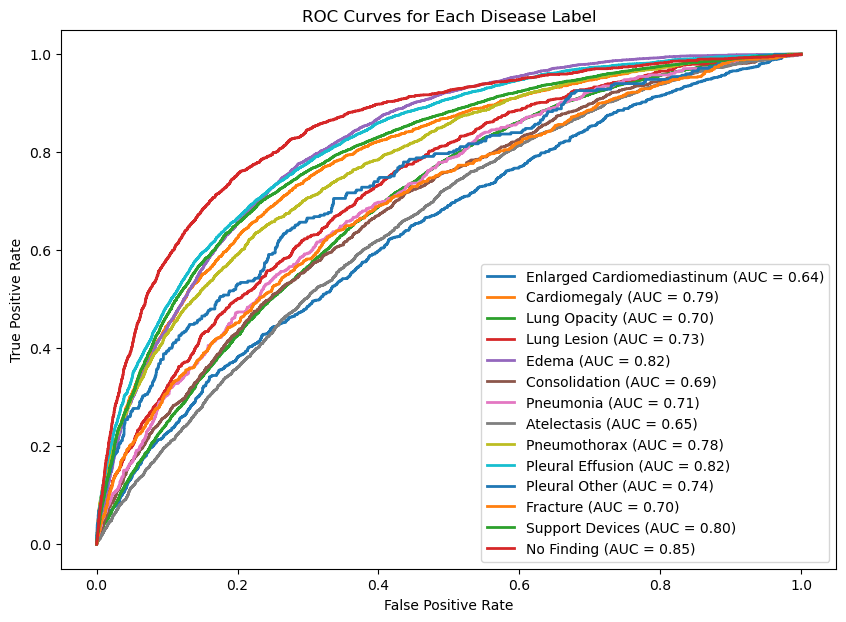

Average ROC AUC across all labels: 0.7441196855181779


In [60]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Verify data shapes and types first
print("Shape of y_pred_prob:", y_pred_prob.shape)
print("Shape of df_test[labels_Columns].values:", df_test[labels_Columns].values.shape)

# Check if predictions are binary or probabilities
if np.any((y_pred_prob < 0) | (y_pred_prob > 1)):
    print("Warning: y_pred_prob contains values outside [0, 1] range.")

# Plot ROC Curves for each disease label
plt.figure(figsize=(10, 7))
roc_auc_scores = []

for i, label_name in enumerate(labels_Columns):
    # Extract true and predicted values for the current label
    y_true = df_test[labels_Columns].values[:, i]
    y_scores = y_pred_prob[:, i]

    # Calculate ROC curve and AUC for the label
    try:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')
    except ValueError as e:
        print(f"Skipping {label_name} due to error: {e}")

# Add plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC if no labels were skipped
if roc_auc_scores:
    average_roc_auc = np.mean(roc_auc_scores)
    print("Average ROC AUC across all labels:", average_roc_auc)
else:
    print("No ROC AUC scores calculated due to data issues.")


In [61]:

def make_pred_multilabel(model, test_dataset, validation_dataset, test_df):
  
    #Load  pre-trained Keras model
    PRED_LABELS = labels_Columns

    for mode in ["Threshold", "test"]:
        # Create empty dataframes
        pred_df = pd.DataFrame(columns=["Path"])
        bi_pred_df = pd.DataFrame(columns=["Path"])
        true_df = pd.DataFrame(columns=["Path"])

        if mode == "Threshold":
            data = validation_dataset  # Use validation dataset for threshold mode
            Eval_df = pd.DataFrame(columns=["label", 'bestthr'])
            thrs = []

        if mode == "test":
            data = test_dataset  # Use test dataset for test mode
            index=0
            TestEval_df = pd.DataFrame(columns=["label", 'auc', "auprc","accuracy"])

            Eval = pd.read_csv("Threshold.csv")  # Load threshold values from the CSV
            Eval.head(14)
            thrs = [Eval["bestthr"][Eval[Eval["label"] == label].index[0]] for label in PRED_LABELS]

            print("thrs :",thrs)

        for inputs, labels in data:
            # Get predictions from the pre-trained model
            # inputs = tf.constant(inputs, dtype=tf.float32)
            true_labels = labels.numpy()
            model.set_weights(model.get_weights())

            """ perform inference
              ... use tf.expand_dims(inputs, axis=0) adds an extra dimension at axis 0,
              ... effectively creating a batch of size 1. """

            inputs_batched = tf.expand_dims(inputs, axis=0)
            outputs = model(inputs_batched, training=False)
            probs = outputs.numpy()

            thisrow = {}
            bi_thisrow = {}
            truerow = {}

            thisrow['Path']='Path'
            truerow['Path']='Path'

            if mode == "test":
              path=test_df.iloc[index]['Path']
              bi_thisrow['Path']=path

            # Iterate over each entry in prediction vector; each corresponds to an individual label
            for j, _label in enumerate(PRED_LABELS):
                thisrow["prob_" + _label] = probs[0][j]
                truerow[_label] = true_labels[j]

                if mode == "test":
                   bi_thisrow["bi_" + _label] = probs[0][j] >= thrs[j]

            pred_df = pd.concat([pred_df, pd.DataFrame([thisrow])], ignore_index=True)
            true_df = pd.concat([true_df, pd.DataFrame([truerow])], ignore_index=True)

            if mode == "test":
              #Explicitly cast object-dtype columns with boolean values to bool
              bool_columns = [col_name for col_name in bi_pred_df.columns if col_name != 'path'
               and bi_pred_df[col_name].dtype == 'object']
              bi_pred_df[bool_columns] = bi_pred_df[bool_columns].astype(bool)

              #Append the dictionary to the DataFrame
              bi_pred_df = pd.concat([bi_pred_df, pd.DataFrame([bi_thisrow])], ignore_index=True)
              index=index+1

        #print(f'Last indext in thershold : {index}')
        for column in true_df:
          if column not in PRED_LABELS:
            continue
          actual = true_df[column]
          pred = pred_df["prob_" + column]

          thisrow = {}
          thisrow['label'] = column
          if mode == "test":
            bi_pred = bi_pred_df["bi_" + column]
            thisrow['auc'] = np.nan
            thisrow['accuracy'] = np.nan
            thisrow['auprc'] = np.nan
          else:
            thisrow['bestthr'] = np.nan

          try:
            if mode == "test":
              # Calculate the AUC using the true labels and predicted probabilities
              thisrow['auc'] =sklm.roc_auc_score(actual.astype(int),pred)

              thisrow['auprc'] = sklm.average_precision_score(
                  actual.astype(int), pred)

              #Calculate accuracy
              thisrow['accuracy'] = sklm.accuracy_score(actual.astype(int), bi_pred)
            else:

              p, r, t = sklm.precision_recall_curve(actual.astype(int), pred)

              #Calculate F1-score, handling division by zero
              f1_scores = []
              for precision, recall in zip(p, r):
                if precision + recall == 0:
                  f1_scores.append(0.0)  # Handle division by zero
                else:
                  f1_scores.append(2 * (precision * recall) / (precision + recall))

              #Find the threshold that maximizes F1-score
              best_threshold = t[np.argmax(f1_scores)]

              thrs.append(best_threshold)
              thisrow['bestthr'] = best_threshold

          except BaseException as be:
            #Handle the exception
            print(f'can not caclucalte AUC and Accuracy for  : {str(column)}, see the error : {str(be)}')

          if mode == "Threshold":
            Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)

          if mode == "test":
            TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


        if mode == "Threshold":
          Eval_df.to_csv("Threshold.csv", index=False)

        if mode == "test":
          TestEval_df.to_csv("TestEval.csv", index=False)
          bi_pred_df.to_csv("bipred.csv", index=False)


    avg_AUC=TestEval_df['auc'].sum()/14.0
    avg_accuracy=TestEval_df['accuracy'].sum() /14.0

    print("AUC ave:", round(avg_AUC,2))
    #print("auprc ave:", TestEval_df['auprc'].sum() / 14.0)
    print("Accuracy ave:", round(avg_accuracy,2))
    print("done")
  
    #return pred_df, Eval_df, bi_pred_df,TestEval_df

In [62]:
#path_image = path_to_image_files  # Replace with the path to your image files
make_pred_multilabel(model,test_dataset,validation_dataset,df_test)

C:\Users\gebre\AppData\Local\Temp\ipykernel_6192\3786497249.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)


thrs : [0.08022316, 0.20057693, 0.34493607, 0.08358415, 0.2791314, 0.09334874, 0.05384423, 0.14704022, 0.19708325, 0.3512227, 0.043803632, 0.069913544, 0.3826395, 0.22612913]
AUC ave: 0.74
Accuracy ave: 0.79
done


C:\Users\gebre\AppData\Local\Temp\ipykernel_6192\3786497249.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)
